In [1]:
from dpks.quant_matrix import QuantMatrix
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
from functools import reduce

def get_most_important_proteins(n):
    Shap = pd.read_csv('../ShapConnections.csv')
    proteins = Shap[Shap['source layer'] == 0]
    proteins = proteins.groupby(['source','type'], as_index=False).mean()
    proteins = proteins.groupby('source', as_index=False).sum()
    proteins.sort_values('value', ascending=False, inplace=True)
    top_n = proteins['source'][0:n]
    return top_n.to_list()

def get_proteins_triv_name(proteins):
    human_proteome = pd.read_csv('../data/human_proteome.gz')
    human_proteome['accession'] = human_proteome['accession'].apply(lambda x: x.split('_')[0])
    names = []
    for protein in proteins:
        if protein in human_proteome['accession'].values:
            m = human_proteome.loc[human_proteome['accession'] == protein]['trivname'].values
            assert len(m) == 1
            m = m[0].split('_')[0]
        else:
            m = protein
        names.append(m)
    return names


In [3]:

qm = QuantMatrix(quantification_file="../data/ms/inner.tsv", 
                    design_matrix_file="../data/ms/inner_design_matrix.tsv")
df = qm.normalize(method='mean', use_rt_sliding_window_filter=True).quantify(method='maxlfq').to_df()
df['Protein'] = get_proteins_triv_name(df['Protein'])


/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


In [24]:
top_proteins = get_most_important_proteins(10)
top_proteins = ['APOA1', 'APOB',  'APOA4','CATZ', 'CD14', 'ACTB','OSTP', 'H2A1B',  'CO1A1', 'H2B1A']
samples1 = qm.get_samples(group=1)
samples2 = qm.get_samples(group = 2)
top_df = df[df['Protein'].isin(top_proteins)]
top_df = top_df[samples1+samples2].T
X = top_df.fillna(0).to_numpy()
X = StandardScaler().fit_transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


     index_x  class        Sample  index_y  Group  same
0          4      1  TM_M2012_010        7      1  True
1         39      1  TM_M2012_011        8      1  True
2         72      1  TM_M2012_012        9      1  True
3          2      1  TM_M2012_013       10      1  True
4         51      1  TM_M2012_014       11      1  True
..       ...    ...           ...      ...    ...   ...
192      193      2  TM_M2012_198      192      2  True
193      192      2  TM_M2012_199      193      2  True
194       58      2  TM_M2012_200      194      2  True
195      191      2  TM_M2012_202      195      2  True
196      190      2  TM_M2012_203      196      2  True

[197 rows x 6 columns]


True     191
False      6
Name: same, dtype: int64

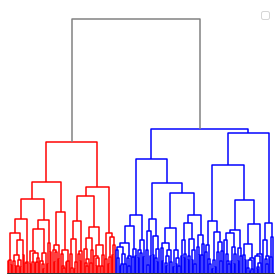

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy


plt.figure(figsize=(4,4))
linkage_data = linkage(X, method='ward', metric='euclidean', optimal_ordering=True)
hierarchy.set_link_color_palette(['r','b'])
d = dendrogram(linkage_data, above_threshold_color='gray')
plt.xticks([])
plt.yticks([])
sns.despine(left=True, top=True, bottom=False, right=True)
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/clustering/Dendogram.jpg', dpi=300, bbox_inches='tight')

d_zip = pd.DataFrame({'index':d['leaves'], 'class':d['leaves_color_list'], 'Sample':samples1+samples2})
design = pd.read_csv("../data/ms/inner_design_matrix.tsv", sep="\t")
design = design.reset_index()
d_zip = d_zip.merge(design, how='inner', on='Sample')
d_zip['class'] = d_zip['class'].map({'r':1,'b':2})
d_zip['same'] = d_zip['class'] == d_zip['Group']
print(d_zip)
d_zip['same'].value_counts()

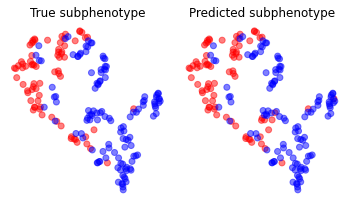

In [26]:
import umap
from sklearn.decomposition import PCA

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

fig,ax = plt.subplots(1,2,figsize=(5,3))
ax[0].scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    c = [c for c in d_zip['Group'].map({1:'red',2:'blue'})],
    alpha=0.5,
    )
ax[0].set_title('True subphenotype')

ax[1].scatter(
    x=embedding[:, 0],
    y=embedding[:, 1],
    c = [c for c in d_zip['class'].map({1:'red',2:'blue'})],
    alpha=0.5,
    )
ax[1].set_title('Predicted subphenotype')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
sns.despine(left=True, top=True, bottom=True, right=True)
plt.savefig('../plots/clustering/UMAP.jpg', dpi=300, bbox_inches='tight')


(197, 3)


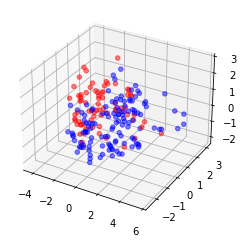

In [27]:

pca = PCA(n_components=3)
pcs = pca.fit_transform(X)
print(np.shape(pcs))
fig = plt.figure()
np.random.seed(42)
ax = fig.add_subplot(projection='3d')
scatter  = ax.scatter(
    xs=pcs[:, 0],
    ys=pcs[:, 1],
    zs = pcs[:,2],
    c = [c for c in d_zip['Group'].map({1:'red',2:'blue'})],
    alpha=0.5,
    )

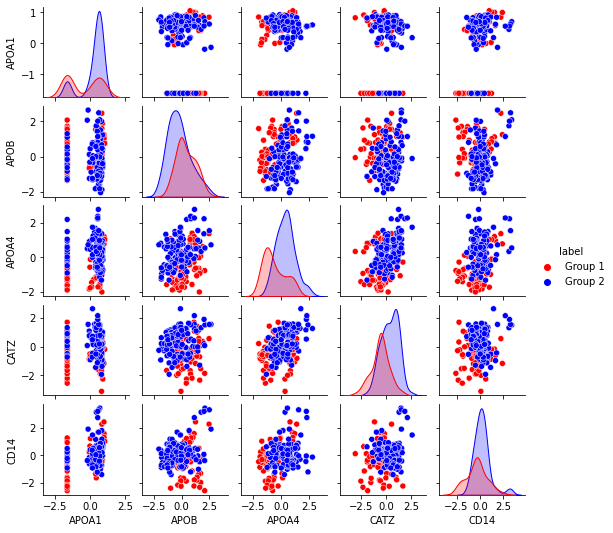

In [29]:
show_n = 5
X_N = X[:,0:show_n]
df_X = pd.DataFrame(X_N)
df_X.columns = top_proteins[0:show_n]

df_X['label'] = d_zip['Group']
df_X['label'] = df_X['label'].map({1:'Group 1', 2:'Group 2'})
g = sns.pairplot(df_X, hue="label", diag_kind='kde',height=1.5, palette=['red','blue'])

plt.savefig('../plots/clustering/Correlation.jpg', dpi=300, bbox_inches='tight')